In [1]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px # to plot the time series plot
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
import tensorflow as tf 
from scipy import stats

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# I. Load data

In [2]:
OF = pd.read_pickle("OF_res.pkl")
DJIA = pd.read_pickle("DJIA_filled_missing_val.pkl")

In [3]:
DJIA.head()

,Dates,Close
0,2022-04-20,35160.789062
1,2022-04-21,34792.761719
2,2022-04-22,33811.398438
3,2022-04-23,33930.429688
4,2022-04-24,33989.945312


In [4]:
OF.head()

,tweets_processed,tweet_size,positive_point,negative_point,ratio,norm_ratio
date_processed,,,,,,
2022-05-01,"[customized, operator, training, helping, team...",142,34.5,1.0,34.500000,4.081169
2022-05-02,"[power, higher, education, one, network, time,...",413,72.0,15.0,4.800000,-0.462093
2022-05-03,"[ambulances, make, india, bharti, airtel, hosp...",425,86.0,17.5,4.914286,-0.444611
2022-05-04,"[cisco, calculates, emissions, products, math,...",438,100.0,15.0,6.666667,-0.176546
2022-05-05,"[employees, said, able, work, remotely, made, ...",474,79.0,15.0,5.266667,-0.390707


# 2. Prepare dataset

input: 
1. The past 3 days of DJIA values
2. The same combination data of our Opinion Finder mood time series (past 3 days)

Time period (in thesis): 
> Train: 2008-2-28 ~ 2008-11-28 (10 months)

> Test: 2008-12-1 ~ 2008-12-19 (19 days)

Time period (in this project): 
> Train: 2022-5-4 ~ 2022-6-10 (38 days)

> Test: 2022-6-13 ~ 2022-6-30 (18 days)

In [5]:
# for i in range(1, 4):
#     DJIA_prim['DJIA_'+str(i)+'_days_before'] = DJIA_prim['Close'].shift(i)
    
# DJIA_prim = DJIA_prim.query(' "2022-04-30" < Dates < "2022-7-01"').reset_index(drop=True)

# Train_DJIA = DJIA_prim.query(' "2022-5-4" <= Dates <= "2022-6-10"').reset_index(drop=True)
# Test_DJIA = DJIA_prim.query(' "2022-6-13" <= Dates <= "2022-6-30"').reset_index(drop=True)

In [6]:
# OF_prim = OF.drop(columns=['tweets_processed', 'tweet_size', 'positive_point', 'negative_point', 'norm_ratio'])
# for i in range(1, 4):
#     OF_prim['OF_'+str(i)+'_days_before'] = OF_prim['ratio'].shift(i)
    
# OF_prim = OF_prim.reset_index()
# OF_prim = OF_prim.rename({'date_processed': 'Dates'}, axis=1) 
# OF_prim = OF_prim.drop(columns=['ratio'])

# Train_OF = OF_prim.query(' "2022-05-04" <= Dates <= "2022-06-10"').reset_index(drop=True)
# Train_OF = Train_OF.drop(columns=['Dates'])
# Test_OF = OF_prim.query(' "2022-06-13" <= Dates <= "2022-06-30"').reset_index(drop=True)
# Test_OF = Test_OF.drop(columns=['Dates'])

In [7]:
# Train = pd.concat([Train_DJIA, Train_OF], axis=1)
# Test = pd.concat([Test_DJIA, Test_OF], axis=1)

In [8]:
DJIA_prim = DJIA.copy()
OF_prim = OF.drop(columns=['tweets_processed', 'tweet_size', 'positive_point', 'negative_point', 'norm_ratio'])
OF_prim = OF_prim.reset_index()
OF_prim = OF_prim.rename({'date_processed': 'Dates'}, axis=1) 

Train_DJIA = DJIA_prim.query(' "2022-5-4" <= Dates <= "2022-6-10"').reset_index(drop=True)
Test_DJIA = DJIA_prim.query(' "2022-6-13" <= Dates <= "2022-6-30"').reset_index(drop=True)

Train_OF = OF_prim.query(' "2022-05-04" <= Dates <= "2022-06-10"').reset_index(drop=True)
Train_OF = Train_OF.drop(columns=['Dates'])
Test_OF = OF_prim.query(' "2022-06-13" <= Dates <= "2022-06-30"').reset_index(drop=True)
Test_OF = Test_OF.drop(columns=['Dates'])

Train = pd.concat([Train_DJIA, Train_OF], axis=1)
Test = pd.concat([Test_DJIA, Test_OF], axis=1)

In [9]:
Train

,Dates,Close,ratio
0,2022-05-04,34061.058594,6.666667
1,2022-05-05,32997.968750,5.266667
2,2022-05-06,32899.371094,5.542857
3,2022-05-07,32572.535156,4.600000
4,2022-05-08,32409.117188,24.000000
5,2022-05-09,32245.699219,4.200000
6,2022-05-10,32160.740234,5.016667
7,2022-05-11,31834.109375,7.400000
8,2022-05-12,31730.300781,3.950000
9,2022-05-13,32196.660156,3.022222


In [10]:
Test

,Dates,Close,ratio
0,2022-06-13,30516.740234,3.021053
1,2022-06-14,30364.830078,2.568421
2,2022-06-15,30668.529297,3.508333
3,2022-06-16,29927.070312,13.120000
4,2022-06-17,29888.779297,7.425000
5,2022-06-18,30209.514648,15.800000
6,2022-06-19,30369.882324,3.850000
7,2022-06-20,30450.066162,3.400000
8,2022-06-21,30530.250000,2.200000
9,2022-06-22,30483.130859,3.346667


# III. Build Neural Network model to predict DJIA
Part 1 : 只提供過去三天收盤價資訊

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
train1 = Train[['Dates', 'Close']].set_index('Dates')
test1 = Test[['Dates', 'Close']].set_index('Dates')

In [13]:
scaler.fit(train1)
scaled_train1 = scaler.transform(train1)
scaled_test1 = scaler.transform(test1)

In [14]:
scaled_train1[:10]

array([[1.        ],
       [0.62139701],
       [0.58628298],
       [0.46988542],
       [0.41168664],
       [0.35348786],
       [0.32323103],
       [0.20690651],
       [0.16993668],
       [0.33602335]])

In [15]:
print(scaled_train1.shape)
print(scaled_test1.shape)

(38, 1)
(18, 1)


In [16]:
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 3
n_features = 1
generator = TimeseriesGenerator(scaled_train1, scaled_train1, length=n_input, batch_size=1)

In [17]:
X,y = generator[0]
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.         0.62139701 0.58628298]
Predict this y: 
 [[0.46988542]]


In [18]:
print(X.shape)
print(y.shape)
print(len(generator))

(1, 3, 1)
(1, 1)
35


In [19]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [20]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
35/35 [==============================] - 1s 2ms/step - loss: 0.0987
Epoch 2/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0279
Epoch 3/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0289
Epoch 4/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0278
Epoch 5/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 6/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0267
Epoch 7/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0255
Epoch 8/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0258
Epoch 9/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0257
Epoch 10/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0294
Epoch 11/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0244
Epoch 12/50
35/35 [==============================] - 0s 2ms/step - loss: 0.0249
Epoch 13/50
35/35 [==============================

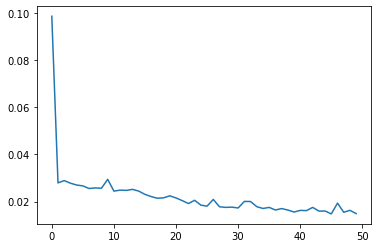

In [21]:
# Loss 
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [23]:
# check result
test_predictions = []

first_eval_batch = scaled_train1[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test1)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
true_predictions = scaler.inverse_transform(test_predictions)

In [24]:
test1['Predictions'] = true_predictions
test1

,Close,Predictions
Dates,,
2022-06-13,30516.740234,31354.174391
2022-06-14,30364.830078,31407.743308
2022-06-15,30668.529297,31602.144423
2022-06-16,29927.070312,31741.290602
2022-06-17,29888.779297,31860.637543
2022-06-18,30209.514648,31945.876768
2022-06-19,30369.882324,32008.751773
2022-06-20,30450.066162,32047.316475
2022-06-21,30530.250000,32069.354164


In [ ]:
test1['Close'].max()

# IV. Compute MAPE & Direction correct rate

In [50]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

def direction(actual, pred): 
    prev_act = actual[0]
    prev_pred = pred[0]
    true = []
    res = []
    for i, j in zip(actual[1:], pred[1:]): 
        if i>=prev_act:
            true.append(1)
        else:
            true.append(-1)
        if j>=prev_pred:
            res.append(1)
        else:
            res.append(-1)
        prev_act = i
        prev_pred = j
    denorminator = len(actual) -1
    numerator = 0
    for i, j in zip(true, res):
        if i==j:
            numerator += 1
    return (numerator / denorminator)

In [57]:
# Part 1 -> past three days' DJIA data
print("MAPE for scenario 1: ", mape(test1['Close'], test1['Predictions']).round(3), "%")
print("Directional correction rate  for scenario 1:", "{0:.0%}".format(direction(test1['Close'], test1['Predictions'])) )

MAPE for scenario 1:  4.013 %
Directional correction rate  for scenario 1: 71%


<AxesSubplot:xlabel='Dates'>

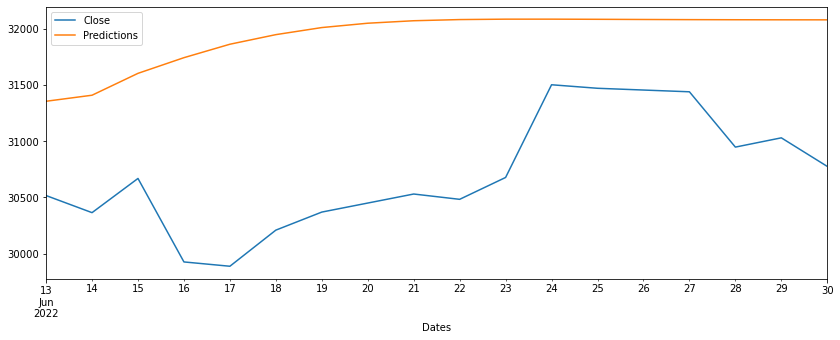

In [38]:
test1.plot(figsize=(14,5))